In [1]:
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm as tqdm
from keras.models import load_model
from keras import backend as K
from datetime import datetime

# from Dental_Tool.Inception import create_inception_v4
from Dental_Tool.Data_processing import *
from Dental_Tool.Dental_Model import *
from Dental_Tool.Process_results import *
from Dental_Tool.Dataloader import *
from Dental_Tool.KFold_v3 import *

import keras.backend as K 
import matplotlib.pyplot as plt
import collections
import numpy as np
import keras
import time

Using TensorFlow backend.


In [2]:
directory = [ 
                "Dental_Data/PBL/10_interdental_20201015_multilabel_max4", 
                "Dental_Data/PBL/10_interdental_20201015_multilabel_max4_flip", 
                "Dental_Data/PBL/10_interdental_20201015_clahe_multilabel_max4", 
                "Dental_Data/PBL/10_interdental_20201015_clahe_multilabel_max4_flip"
            ]


# directory = [ 
#                 "Dental_Data/PBL/10_20201015_multilabel", 
#                 "Dental_Data/PBL/10_20201015_multilabel_flip", 
#                 "Dental_Data/PBL/10_20201015_clahe_multilabel", 
#                 "Dental_Data/PBL/10_20201015_clahe_multilabel_flip"
#             ]

directory = [ i + "/mapping.json" for i in directory]
argscale_num = len(directory) * 20

def load_json(data_list, interdental=False):
            filter_fun = lambda x : { path: max(list(map(int, state))) for path, state in x.items() if max(list(map(int, state))) >= 0 }
               
            interdental_fun = lambda x : { path: state for path, state in x.items() }
            
            results = collections.OrderedDict()
            all_filtering_data, all_keys = [], []
            
            for dataset_path in data_list:
                        mapping_data = json.load(open(dataset_path , "r"))
                        filter_data  = filter_fun(mapping_data) if not interdental else interdental_fun(mapping_data)
                        all_filtering_data.append(filter_data)
                        all_keys.append( list(filter_data.keys()) )
            
            for keys in zip(*all_keys):
                    for key,  data in zip(keys, all_filtering_data):
                            results[key] = data[key]        
            return results

In [3]:
def json_2_dataframe_PBL_Multitask(data, mode=None):
        PBL_Columns = ["Path", "State", "Class", "bone_loss", "furcation", "buccal_furcation", "endo_lesion"]
        dataframe = pd.DataFrame(columns=PBL_Columns)
        data_dict = collections.OrderedDict()
        counter = 0
        
        molar = [1, 2, 3, 14, 15, 16, 17, 18, 19, 30, 31, 32]
        premolar = [ 4, 5, 12, 13, 20, 21, 29, 30 ]
        
        less_data  = [1, 16, 17, 32]
        
        for path, info in data.items():
                state = max(info["state"])
                bone_loss = max(info["bone_loss"])
                item = { 
                          "Path": path,
                          "State": state,
                          "Class": state-1 if state > 1 else 0,
                          "bone_loss": bone_loss 
                }
                
                path_split = path.split("_")
                
#                 in_dir = path.split("/")[2]

                NN_IDX = 0
                for idx, i in enumerate(path_split):
                        if i == "NN":
                            NN_IDX = idx
                            break
                
                original, source = "", ""
                
                if NN_IDX == 0:
                        source = "_".join(path_split[-6:-1]) 
                        original = "_".join(path_split[-6:-2])
                
                else: 
                        source = "_".join(path_split[NN_IDX:-1])
                        original = "_".join(path_split[NN_IDX:-2])
                
                item["ori_src"] = original
                item["source"] = source
                item["tooth_num"] = int(path_split[-2])
                
                if (mode == "molar" and (item["tooth_num"] not in molar)   ) or (mode == "premolar" and (item["tooth_num"] not in premolar) ): continue 
                    
                item["angle"] = int(path_split[-1].split(".")[0])
                
                data_dict[counter] = item
                counter += 1        

        dataframe = dataframe.from_dict(data_dict, "index")
        
        return dataframe

In [4]:
def json_2_dataframe_PBL_inderdental(data, mode=None):
        PBL_Columns = ["Path", "State", "Class", "bone_loss", "furcation", "buccal_furcation", "endo_lesion"]
        dataframe_L, dataframe_R  = pd.DataFrame(columns=PBL_Columns), pd.DataFrame(columns=PBL_Columns)
        data_dict_L, data_dict_R  = collections.OrderedDict(), collections.OrderedDict()   
        counter_L, counter_R = 0, 0
        
        molar = [1, 2, 3, 14, 15, 16, 17, 18, 19, 30, 31, 32]
        premolar = [ 4, 5, 12, 13, 20, 21, 29, 30 ]
        
        less_data  = [1, 16, 17, 32]
        
        for path, info in data.items():
                state = info["state"]
                item = { 
                          "Path": path,
                          "State": state,
                          "Class": state-1 if state > 1 else 0,
                          **info
                }
                
                path_split = path.split("_")
                
#                 in_dir = path.split("/")[2]

                NN_IDX = 0
                for idx, i in enumerate(path_split):
                        if i == "NN":
                            NN_IDX = idx
                            break
                
                original, source = "", ""
                
                if NN_IDX == 0:
                        source = "_".join(path_split[-7:-2]) 
                        original = "_".join(path_split[-7:-3])
                
                else: 
                        source = "_".join(path_split[NN_IDX:-2])
                        original = "_".join(path_split[NN_IDX:-3])
                
                item["ori_src"] = original
                item["source"] = source
                item["side"] = source + "_" + path[-5]
#                 if 'L' == path[-5]: item["source"] = source + '_L' 
#                 elif 'R'== path[-5]: item["source"] = source + '_R'
#                 if 
#                 else: raise ValueError
                
                item["tooth_num"] = int(path_split[-3])
                
                if (mode == "molar"    and item["tooth_num"] not in molar   ) or (mode == "premolar" and item["tooth_num"] not in premolar): continue 
                
                item["angle"] = int(path_split[-2].split(".")[0])
                
                if 'L' == path[-5]:
                        data_dict_L[counter_L] = item
                        counter_L += 1        
                
                if 'R' == path[-5]:
                        data_dict_R[counter_R] = item
                        counter_R += 1        

        
        dataframe_L = dataframe_L.from_dict(data_dict_L, "index")
        dataframe_R = dataframe_R.from_dict(data_dict_R, "index")
        
        dataframe = pd.concat([dataframe_L, dataframe_R])
        
        return dataframe

In [5]:
data = load_json(directory, interdental=True)
dataset = json_2_dataframe_PBL_inderdental(data)
# dataset = json_2_dataframe_PBL_Multitask(data)
dataset = dataset[ (dataset["State"] >=0) & (dataset["State"] >=0) & (dataset["bone_loss"] >=0) & ( dataset["furcation"] >= 0 ) & ( dataset["furcation"] < 2 ) ]

# tooth_group = dataset.groupby("source")
# groups = [ table for source, table in tooth_group ]
# random.shuffle(groups)
groups = [ tooth_table for ori_src, table in dataset.groupby("ori_src") for src, teeth_table in table.groupby("source") for src_side, tooth_table in teeth_table.groupby("side") ]
dataset = pd.concat(groups).reset_index(drop=True)

dataset.to_csv("tmp.csv", index=False)
dataset

,Path,State,Class,state,bone_loss,furcation,buccal_furcation,endo_lesion,ori_src,source,side,tooth_num,angle
0,Dental_Data/PBL/10_interdental_20201015_multil...,1,0,1,1,0,-999,0,158877 Patrica M Potter_190702_103643_B2D949,158877 Patrica M Potter_190702_103643_B2D949_10,158877 Patrica M Potter_190702_103643_B2D949_10_L,10,-10
1,Dental_Data/PBL/10_interdental_20201015_multil...,1,0,1,1,0,-999,0,158877 Patrica M Potter_190702_103643_B2D949,158877 Patrica M Potter_190702_103643_B2D949_10,158877 Patrica M Potter_190702_103643_B2D949_10_L,10,-10
2,Dental_Data/PBL/10_interdental_20201015_clahe_...,1,0,1,1,0,-999,0,158877 Patrica M Potter_190702_103643_B2D949,158877 Patrica M Potter_190702_103643_B2D949_10,158877 Patrica M Potter_190702_103643_B2D949_10_L,10,-10
3,Dental_Data/PBL/10_interdental_20201015_clahe_...,1,0,1,1,0,-999,0,158877 Patrica M Potter_190702_103643_B2D949,158877 Patrica M Potter_190702_103643_B2D949_10,158877 Patrica M Potter_190702_103643_B2D949_10_L,10,-10
4,Dental_Data/PBL/10_interdental_20201015_multil...,1,0,1,1,0,-999,0,158877 Patrica M Potter_190702_103643_B2D949,158877 Patrica M Potter_190702_103643_B2D949_10,158877 Patrica M Potter_190702_103643_B2D949_10_L,10,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
320155,Dental_Data/PBL/10_interdental_20201015_clahe_...,3,2,3,2,0,-999,0,NN__191111_145426_24211,NN__191111_145426_24211_7,NN__191111_145426_24211_7_R,7,8
320156,Dental_Data/PBL/10_interdental_20201015_multil...,3,2,3,2,0,-999,0,NN__191111_145426_24211,NN__191111_145426_24211_7,NN__191111_145426_24211_7_R,7,9
320157,Dental_Data/PBL/10_interdental_20201015_multil...,3,2,3,2,0,-999,0,NN__191111_145426_24211,NN__191111_145426_24211_7,NN__191111_145426_24211_7_R,7,9
320158,Dental_Data/PBL/10_interdental_20201015_clahe_...,3,2,3,2,0,-999,0,NN__191111_145426_24211,NN__191111_145426_24211_7,NN__191111_145426_24211_7_R,7,9


In [6]:
def Inception_Multitask(input_shape):
        input_tensor = Input(shape=input_shape)
        base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        
        class_branch = Dense(3, activation='softmax', name='class_output')(x)
        HV_branch = Dense(3, activation='softmax', name='HV_output')(x)
        Fur_branch = Dense(2, activation='softmax', name='Fur_output')(x)

        model = Model(inputs=input_tensor, outputs=[HV_branch, class_branch, Fur_branch])
        
#         regularizer = l2(0.00001)

#         for layer in base_model.layers:
#                 for attr in ['kernel_regularizer']:
#                         if hasattr(layer, attr):
#                                 setattr(layer, attr, regularizer)
        
        opt = keras.optimizers.RMSprop(lr=1e-3)
        model.compile(optimizer='rmsprop',
              loss={
                    'class_output': 'categorical_crossentropy', 
                    'HV_output'   : 'categorical_crossentropy',
                    'Fur_output'  : 'categorical_crossentropy'
                   },
              loss_weights={'class_output': .70, 'HV_output': 0.15, 'Fur_output': 0.15 },
              metrics=['accuracy']
             )
    
        return model
    
model = Inception_Multitask(input_shape=(200, 180, 1))

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 180, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 89, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 89, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 89, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [8]:
class DataGenerator(keras.utils.Sequence):
        'Generates data for Keras'
        def __init__(self, list_IDs, labels, batch_size=32, dim=(256, 256), n_channels=1,
                     n_classes=10, shuffle=True, resize_setting=(256, 256)):
                'Initialization'
                self.dim = dim
                self.batch_size = batch_size
                self.labels = labels
                self.list_IDs = list(list_IDs)
                self.n_channels = n_channels
                self.n_classes = n_classes
                self.shuffle = shuffle
                self.on_epoch_end()
                self.resize_setting = resize_setting
                

        def __len__(self):
                'Denotes the number of batches per epoch'
                return int(np.ceil(len(self.list_IDs) / self.batch_size))

        def __getitem__(self, index):
                'Generate one batch of data'
                # Generate indexes of the batch
                end = (index+1)*self.batch_size if (index+1)*self.batch_size < len(self.indexes) else len(self.indexes)
                indexes = self.indexes[index*self.batch_size:end] 

                # Find list of IDs
                list_IDs_temp = [self.list_IDs[k] for k in indexes]         
                # Generate data
                X, y = self.__data_generation(list_IDs_temp)
                return X, y

        def on_epoch_end(self):
                'Updates indexes after each epoch'
                self.indexes = np.arange(len(self.list_IDs))
                if self.shuffle == True:
                        np.random.shuffle(self.indexes)
        
        def noisy_image(self, noise_typ, image):
                if noise_typ == "gauss":
                          row,col= image.shape
                          mean = 0
                          var = 0.1
                          sigma = var**0.5
                          gauss = np.random.normal(mean,sigma,(row,col))
                          gauss = gauss.reshape(row,col)
                          noisy = image + gauss
                          return noisy

                elif noise_typ == "s&p":
                          row,col = image.shape
                          s_vs_p = 0.5
                          amount = 0.004
                          out = np.copy(image)
                          # Salt mode
                          num_salt = np.ceil(amount * image.size * s_vs_p)
                          coords = [np.random.randint(0, i - 1, int(num_salt))
                                  for i in image.shape]
                          out[coords] = 1

                          # Pepper mode
                          num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
                          coords = [np.random.randint(0, i - 1, int(num_pepper))
                                  for i in image.shape]
                          out[coords] = 0
                          return out

                elif noise_typ == "poisson":
                          vals = len(np.unique(image))
                          vals = 2 ** np.ceil(np.log2(vals))
                          noisy = np.random.poisson(image * vals) / float(vals)
                          return noisy

                elif noise_typ == "speckle":
                          row,col = image.shape
                          gauss = np.random.randn(row,col)
                          gauss = gauss.reshape(row,col)        
                          noisy = image + image * gauss
                          return noisy
            
        def __data_generation(self, list_IDs_temp):
            
                # Initialization
                image_array_size = ( self.batch_size, *self.dim, self.n_channels )
                X = np.zeros(image_array_size, dtype=np.uint8)
                y_HV = np.array([0]* self.batch_size)
                y_class = np.array([0]* self.batch_size)
                y_fur   = np.array([0]* self.batch_size)
                
                for i, ID in enumerate(list_IDs_temp):
                        image = cv2.imread(ID, 0)
                        image = cv2.resize(image, (self.resize_setting[1], self.resize_setting[0]))
                        
#                         from random import sample
#                         random_index = sample(range(0, 32), k=8)
                
#                         if i in random_index: image = self.noisy_image("gauss", image)
                        image = np.reshape(image, (*image.shape, 1))
                        X[i,], y_class[i], y_HV[i], y_fur[i] =  image, self.labels[ID][0], self.labels[ID][1], self.labels[ID][2] 
                
                class_output =  to_categorical(y_class, num_classes=self.n_classes)
                HV_output = to_categorical(y_HV, num_classes=self.n_classes) 
                Fur_output = to_categorical(y_fur, num_classes=2)
                return_y = { 'HV_output': HV_output, 'class_output':class_output, 'Fur_output': Fur_output }
                return X, [HV_output, class_output, Fur_output]

In [9]:
def make_generator_multitask(dataset, batch_size=32):
        common_params = {
                              'batch_size': batch_size,
                              'n_classes' : len(np.unique(dataset.Class)),
                              'n_channels': 1,
                              'shuffle'   : False,
                              'resize_setting': (200, 180),
                              'dim': (200, 180)
        }
        
        dataset_dict = collections.OrderedDict(zip(dataset.Path, dataset.Class))
        
        for idx, item in dataset.iterrows():
                dataset_dict[item["Path"]] = [ item["Class"], item["bone_loss"], item["furcation"] ]
                
        dataset_generator = DataGenerator(dataset["Path"], dataset_dict ,**common_params)
        return dataset_generator
    


In [10]:
def plot_result_Multitask(history, output_dir):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(16,5))
        loss: 0.4421 
#         HV_output_loss: 0.6354 
#         class_output_loss: 0.3522 
#         HV_output_accuracy: 0.7014
#         class_output_accuracy: 0.8612 
                            
#         val_loss: 1.2021 
#         val_HV_output_loss: 0.9517
#         val_class_output_loss: 1.1634 
#         val_HV_output_accuracy: 0.6368 
#         val_class_output_accuracy: 0.6930
        
        plt.subplot(121)
        plt.title("Loss")
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['HV_output_loss'], label='HV Training Loss')
        plt.plot(history.history['class_output_loss'], label='Class Training Loss')
        
        plt.plot(history.history['val_loss'], label = 'Validation Loss')
        plt.plot(history.history['val_HV_output_loss'], label = 'HV Validation Loss')
        plt.plot(history.history['val_class_output_loss'], label = 'Class Validation Loss')
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower right')
        
        plt.subplot(122)
        plt.title("Accuracy")
        plt.plot(history.history['HV_output_accuracy'], label='HV Training Accuracy')
        plt.plot(history.history['class_output_accuracy'], label='Class Training Accuracy')
        
        plt.plot(history.history['val_HV_output_accuracy'], label = 'HV Validation Accuracy')
        plt.plot(history.history['val_class_output_accuracy'], label = 'Class Validation Accuracy')
        
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.1, 1.5])
        plt.legend(loc='lower right')
        
#         target_dir = "Results/%s" % (output_dir)
        if not os.path.isdir(output_dir): os.makedirs(output_dir)
        plt.savefig("%s/history.png" % (output_dir))
        plt.show()

stage 0: 40640, stage 1: 108320, stage 2: 30400, stage 3: 12400
stage 0: 13760, stage 1: 36080, stage 2: 10080, stage 3: 4000
stage 0: 13440, stage 1: 36160, stage 2: 10480, stage 3: 4400
Training dataset: 37200, Validation dataset: 12000, Testing dataset: 13200
set()
set()
set()
Fold 1: loading Inception_Multitask ......
Fold 1: loading Done, cost 3.6659512519836426 seconds
Epoch 1/15
1163/1163 [==============================] - 880s 757ms/step - loss: 0.7934 - HV_output_loss: 0.8955 - class_output_loss: 0.8741 - Fur_output_loss: 0.3148 - HV_output_accuracy: 0.5653 - class_output_accuracy: 0.5901 - Fur_output_accuracy: 0.9019 - val_loss: 1.5172 - val_HV_output_loss: 1.4847 - val_class_output_loss: 1.2530 - val_Fur_output_loss: 0.5151 - val_HV_output_accuracy: 0.6183 - val_class_output_accuracy: 0.6306 - val_Fur_output_accuracy: 0.8788

Epoch 00001: val_class_output_accuracy improved from -inf to 0.63058, saving model to Results/Inception_Multitask_3_Fur_Fold_520201027-165040/Fold_1/In

1163/1163 [==============================] - 214s 184ms/step - loss: 0.0841 - HV_output_loss: 0.3064 - class_output_loss: 0.0402 - Fur_output_loss: 0.0664 - HV_output_accuracy: 0.8930 - class_output_accuracy: 0.9895 - Fur_output_accuracy: 0.9858 - val_loss: 2.2081 - val_HV_output_loss: 1.7494 - val_class_output_loss: 2.7067 - val_Fur_output_loss: 1.9113 - val_HV_output_accuracy: 0.6787 - val_class_output_accuracy: 0.6753 - val_Fur_output_accuracy: 0.8653

Epoch 00014: val_class_output_accuracy did not improve from 0.71808
Epoch 15/15
1163/1163 [==============================] - 214s 184ms/step - loss: 0.0669 - HV_output_loss: 0.2535 - class_output_loss: 0.0321 - Fur_output_loss: 0.0427 - HV_output_accuracy: 0.9027 - class_output_accuracy: 0.9904 - Fur_output_accuracy: 0.9868 - val_loss: 1.4055 - val_HV_output_loss: 1.6071 - val_class_output_loss: 2.1316 - val_Fur_output_loss: 1.4247 - val_HV_output_accuracy: 0.6411 - val_class_output_accuracy: 0.6910 - val_Fur_output_accuracy: 0.8549



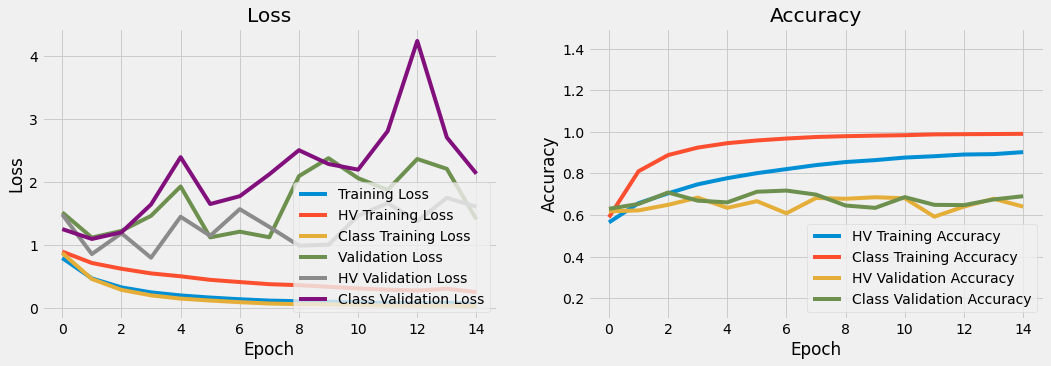

loading Results/Inception_Multitask_3_Fur_Fold_520201027-165040/Fold_1/Inception_Multitask_Fold_1/parameter\weights-improvement-07-0.7181.hdf5 ......
loading Done, cost 59.86291432380676 seconds
413/413 [==============================] - 391s 947ms/step
Accuracy  = 73.63 %


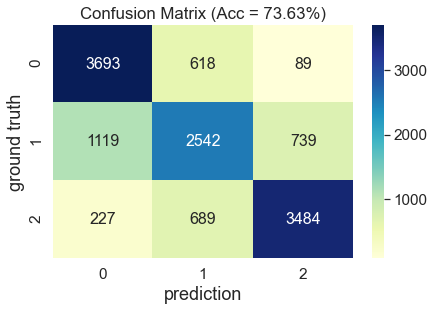

  Class 0 Class 1 Class 2  Acc
0    1986     177      37  90%
1    1707     441      52  78%
2    1119    2542     739  58%
3     227     689    3484  79%
stage 0: 41040, stage 1: 108240, stage 2: 30080, stage 3: 12160
stage 0: 13360, stage 1: 36160, stage 2: 10400, stage 3: 4240
stage 0: 13440, stage 1: 36160, stage 2: 10480, stage 3: 4400
Training dataset: 36480, Validation dataset: 12720, Testing dataset: 13200
set()
set()
set()
Fold 2: loading Inception_Multitask ......
Fold 2: loading Done, cost 3.366191864013672 seconds
Epoch 1/15
1140/1140 [==============================] - 472s 414ms/step - loss: 0.8180 - HV_output_loss: 0.9085 - class_output_loss: 0.9089 - Fur_output_loss: 0.3032 - HV_output_accuracy: 0.5601 - class_output_accuracy: 0.5672 - Fur_output_accuracy: 0.9073 - val_loss: 3.3417 - val_HV_output_loss: 1.1124 - val_class_output_loss: 1.4552 - val_Fur_output_loss: 1.0305 - val_HV_output_accuracy: 0.5072 - val_class_output_accuracy: 0.5411 - val_Fur_output_accuracy: 0.865


Epoch 00013: val_class_output_accuracy did not improve from 0.77253
Epoch 14/15
1140/1140 [==============================] - 209s 183ms/step - loss: 0.0888 - HV_output_loss: 0.3179 - class_output_loss: 0.0470 - Fur_output_loss: 0.0549 - HV_output_accuracy: 0.8706 - class_output_accuracy: 0.9852 - Fur_output_accuracy: 0.9826 - val_loss: 3.0521 - val_HV_output_loss: 2.3854 - val_class_output_loss: 1.9709 - val_Fur_output_loss: 1.2507 - val_HV_output_accuracy: 0.5448 - val_class_output_accuracy: 0.7231 - val_Fur_output_accuracy: 0.8489

Epoch 00014: val_class_output_accuracy did not improve from 0.77253
Epoch 15/15
1140/1140 [==============================] - 210s 184ms/step - loss: 0.0824 - HV_output_loss: 0.3080 - class_output_loss: 0.0404 - Fur_output_loss: 0.0532 - HV_output_accuracy: 0.8761 - class_output_accuracy: 0.9868 - Fur_output_accuracy: 0.9838 - val_loss: 7.6234 - val_HV_output_loss: 95.0702 - val_class_output_loss: 52.8377 - val_Fur_output_loss: 1.8409 - val_HV_output_accur

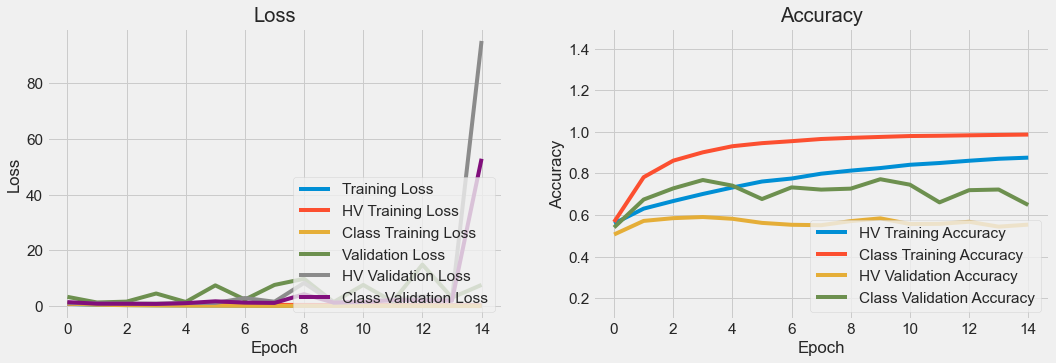

loading Results/Inception_Multitask_3_Fur_Fold_520201027-165040/Fold_2/Inception_Multitask_Fold_2/parameter\weights-improvement-10-0.7725.hdf5 ......
loading Done, cost 74.61472582817078 seconds
413/413 [==============================] - 372s 901ms/step
Accuracy  = 69.05 %


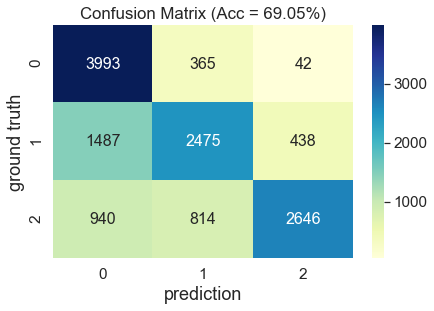

  Class 0 Class 1 Class 2  Acc
0    2141      51       8  97%
1    1852     314      34  84%
2    1487    2475     438  56%
3     940     814    2646  60%
stage 0: 40640, stage 1: 108320, stage 2: 30400, stage 3: 12400
stage 0: 13360, stage 1: 36160, stage 2: 10400, stage 3: 4240
stage 0: 13840, stage 1: 36080, stage 2: 10160, stage 3: 4160
Training dataset: 37200, Validation dataset: 12720, Testing dataset: 12480
set()
set()
set()
Fold 3: loading Inception_Multitask ......
Fold 3: loading Done, cost 38.187219858169556 seconds
Epoch 1/15
1163/1163 [==============================] - 812s 698ms/step - loss: 0.7456 - HV_output_loss: 0.8658 - class_output_loss: 0.8098 - Fur_output_loss: 0.3253 - HV_output_accuracy: 0.5782 - class_output_accuracy: 0.6357 - Fur_output_accuracy: 0.8956 - val_loss: 1.3253 - val_HV_output_loss: 1.3080 - val_class_output_loss: 1.3599 - val_Fur_output_loss: 0.6815 - val_HV_output_accuracy: 0.5565 - val_class_output_accuracy: 0.6193 - val_Fur_output_accuracy: 0.86

1163/1163 [==============================] - 220s 189ms/step - loss: 0.0776 - HV_output_loss: 0.2676 - class_output_loss: 0.0436 - Fur_output_loss: 0.0465 - HV_output_accuracy: 0.8997 - class_output_accuracy: 0.9877 - Fur_output_accuracy: 0.9858 - val_loss: 1.4713 - val_HV_output_loss: 1.2570 - val_class_output_loss: 2.9986 - val_Fur_output_loss: 0.7413 - val_HV_output_accuracy: 0.6037 - val_class_output_accuracy: 0.6087 - val_Fur_output_accuracy: 0.8589

Epoch 00013: val_class_output_accuracy did not improve from 0.68067
Epoch 14/15
1163/1163 [==============================] - 220s 190ms/step - loss: 0.0721 - HV_output_loss: 0.2493 - class_output_loss: 0.0388 - Fur_output_loss: 0.0502 - HV_output_accuracy: 0.9062 - class_output_accuracy: 0.9900 - Fur_output_accuracy: 0.9866 - val_loss: 2.2145 - val_HV_output_loss: 1.2568 - val_class_output_loss: 3.4058 - val_Fur_output_loss: 1.0483 - val_HV_output_accuracy: 0.6303 - val_class_output_accuracy: 0.6303 - val_Fur_output_accuracy: 0.8575



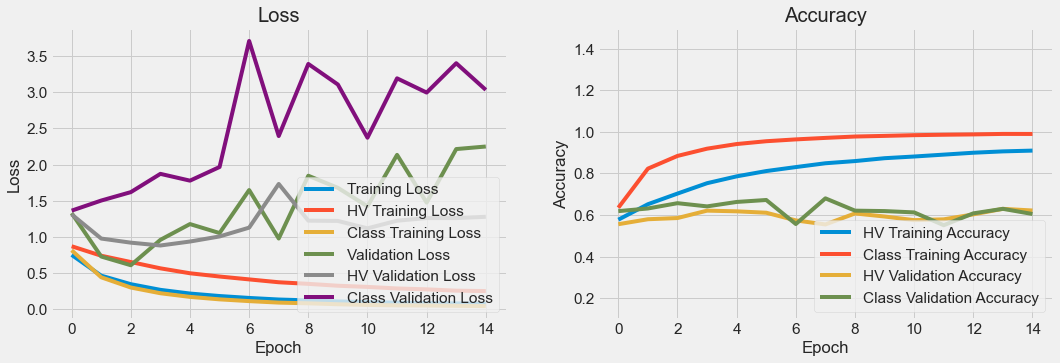

loading Results/Inception_Multitask_3_Fur_Fold_520201027-165040/Fold_3/Inception_Multitask_Fold_3/parameter\weights-improvement-08-0.6807.hdf5 ......
loading Done, cost 101.48989939689636 seconds
390/390 [==============================] - 383s 982ms/step
Accuracy  = 67.32 %


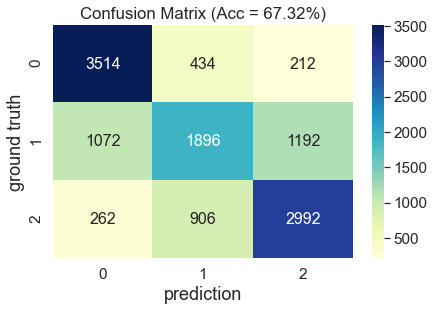

  Class 0 Class 1 Class 2  Acc
0    1866     112     102  90%
1    1648     322     110  79%
2    1072    1896    1192  46%
3     262     906    2992  72%
stage 0: 40400, stage 1: 108320, stage 2: 30640, stage 3: 12240
stage 0: 13760, stage 1: 36080, stage 2: 10080, stage 3: 4000
stage 0: 13680, stage 1: 36160, stage 2: 10240, stage 3: 4560
Training dataset: 36720, Validation dataset: 12000, Testing dataset: 13680
set()
set()
set()
Fold 4: loading Inception_Multitask ......
Fold 4: loading Done, cost 3.509852647781372 seconds
Epoch 1/15
1148/1148 [==============================] - 1506s 1s/step - loss: 0.7933 - HV_output_loss: 0.8884 - class_output_loss: 0.8644 - Fur_output_loss: 0.3665 - HV_output_accuracy: 0.5603 - class_output_accuracy: 0.6027 - Fur_output_accuracy: 0.8733 - val_loss: 2.0290 - val_HV_output_loss: 1.1103 - val_class_output_loss: 1.2132 - val_Fur_output_loss: 0.3958 - val_HV_output_accuracy: 0.5514 - val_class_output_accuracy: 0.6309 - val_Fur_output_accuracy: 0.8969


1148/1148 [==============================] - 253s 220ms/step - loss: 0.0770 - HV_output_loss: 0.2727 - class_output_loss: 0.0405 - Fur_output_loss: 0.0518 - HV_output_accuracy: 0.8941 - class_output_accuracy: 0.9884 - Fur_output_accuracy: 0.9851 - val_loss: 4.2599 - val_HV_output_loss: 13.0228 - val_class_output_loss: 5.5403 - val_Fur_output_loss: 0.6448 - val_HV_output_accuracy: 0.6231 - val_class_output_accuracy: 0.6791 - val_Fur_output_accuracy: 0.8755

Epoch 00014: val_class_output_accuracy did not improve from 0.70600
Epoch 15/15
1148/1148 [==============================] - 253s 221ms/step - loss: 0.0693 - HV_output_loss: 0.2552 - class_output_loss: 0.0351 - Fur_output_loss: 0.0431 - HV_output_accuracy: 0.8982 - class_output_accuracy: 0.9895 - Fur_output_accuracy: 0.9866 - val_loss: 2.1910 - val_HV_output_loss: 10.7796 - val_class_output_loss: 4.8916 - val_Fur_output_loss: 1.3996 - val_HV_output_accuracy: 0.6268 - val_class_output_accuracy: 0.6911 - val_Fur_output_accuracy: 0.8522

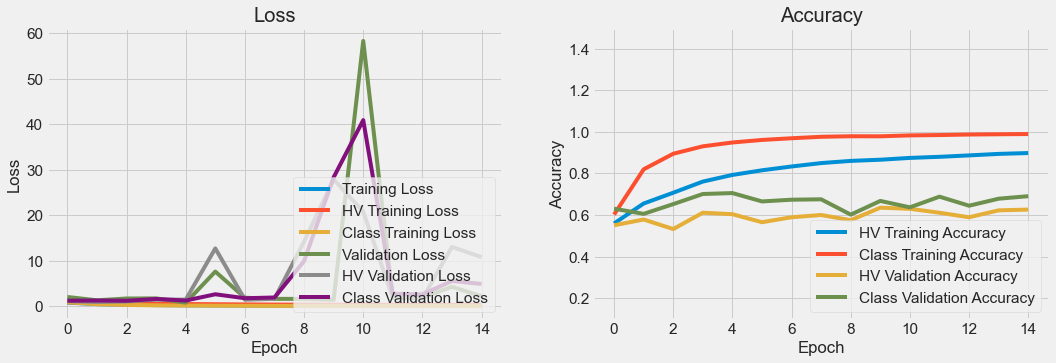

loading Results/Inception_Multitask_3_Fur_Fold_520201027-165040/Fold_4/Inception_Multitask_Fold_4/parameter\weights-improvement-05-0.7060.hdf5 ......
loading Done, cost 129.3117344379425 seconds
428/428 [==============================] - 478s 1s/step
Accuracy  = 69.74 %


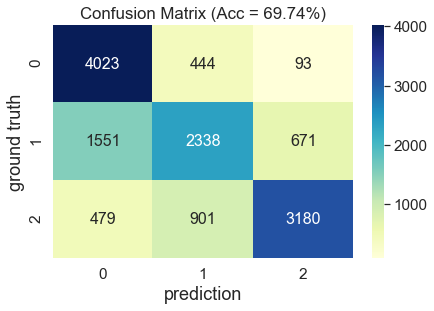

  Class 0 Class 1 Class 2  Acc
0    2148     107      25  94%
1    1875     337      68  82%
2    1551    2338     671  51%
3     479     901    3180  70%
stage 0: 40400, stage 1: 108320, stage 2: 30640, stage 3: 12240
stage 0: 13600, stage 1: 36160, stage 2: 10160, stage 3: 4400
stage 0: 13840, stage 1: 36080, stage 2: 10160, stage 3: 4160
Training dataset: 36720, Validation dataset: 13200, Testing dataset: 12480
set()
set()
set()
Fold 5: loading Inception_Multitask ......
Fold 5: loading Done, cost 3.711031436920166 seconds
Epoch 1/15
1148/1148 [==============================] - 1043s 909ms/step - loss: 0.7554 - HV_output_loss: 0.8955 - class_output_loss: 0.8116 - Fur_output_loss: 0.3527 - HV_output_accuracy: 0.5341 - class_output_accuracy: 0.6251 - Fur_output_accuracy: 0.8793 - val_loss: 1.1313 - val_HV_output_loss: 0.9140 - val_class_output_loss: 0.9429 - val_Fur_output_loss: 0.3842 - val_HV_output_accuracy: 0.5657 - val_class_output_accuracy: 0.7016 - val_Fur_output_accuracy: 0.83

1148/1148 [==============================] - 277s 241ms/step - loss: 0.0666 - HV_output_loss: 0.2592 - class_output_loss: 0.0292 - Fur_output_loss: 0.0489 - HV_output_accuracy: 0.8982 - class_output_accuracy: 0.9920 - Fur_output_accuracy: 0.9849 - val_loss: 0.9665 - val_HV_output_loss: 1.3083 - val_class_output_loss: 3.1487 - val_Fur_output_loss: 0.5052 - val_HV_output_accuracy: 0.5812 - val_class_output_accuracy: 0.6174 - val_Fur_output_accuracy: 0.9053

Epoch 00014: val_class_output_accuracy did not improve from 0.72140
Epoch 15/15
1148/1148 [==============================] - 275s 239ms/step - loss: 0.0609 - HV_output_loss: 0.2475 - class_output_loss: 0.0235 - Fur_output_loss: 0.0488 - HV_output_accuracy: 0.9028 - class_output_accuracy: 0.9931 - Fur_output_accuracy: 0.9848 - val_loss: 8.9093 - val_HV_output_loss: 1.0814 - val_class_output_loss: 2.0737 - val_Fur_output_loss: 0.5879 - val_HV_output_accuracy: 0.6562 - val_class_output_accuracy: 0.7097 - val_Fur_output_accuracy: 0.8596



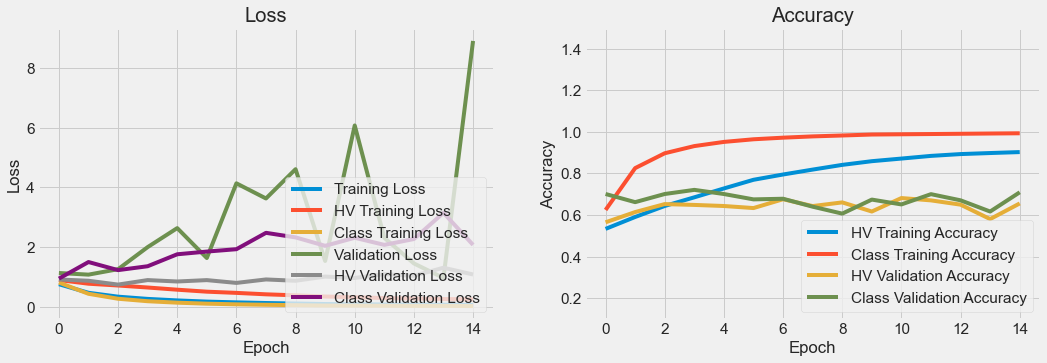

loading Results/Inception_Multitask_3_Fur_Fold_520201027-165040/Fold_5/Inception_Multitask_Fold_5/parameter\weights-improvement-04-0.7214.hdf5 ......
loading Done, cost 105.89518141746521 seconds
390/390 [==============================] - 362s 928ms/step
Accuracy  = 69.51 %


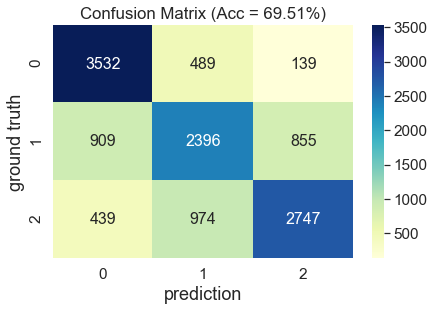

  Class 0 Class 1 Class 2  Acc
0    2002      56      22  96%
1    1530     433     117  74%
2     909    2396     855  58%
3     439     974    2747  66%


In [11]:
# all_models = { "CNN_Net": CNN_Net, "Inception": Inception, "ResNet": ResNet }
root_dir  =  "Inception_Multitask_3_Fur_Fold_5" + datetime.now().strftime("%Y%m%d-%H%M%S")

init_directory(f"Results/{root_dir}/table")

# train_dataset.to_csv("Results/%s/table/train_dataset.csv" % root_dir, index=False)
# valid_dataset.to_csv("Results/%s/table/valid_dataset.csv" % root_dir, index=False)
# test_dataset.to_csv ("Results/%s/table/test_dataset.csv"  % root_dir, index=False)


# balance_dataset = pd.concat([train_dataset, valid_dataset, test_dataset])
# balance_dataset.to_csv("Results/%s/table/balance_dataset.csv"   % root_dir, index=False)

# model_info = ("Inception_v4_Net", create_inception_v4)
model_info = ("Inception_Multitask", Inception_Multitask)

performance_list = []

epochs     = 15
Fold_num = 5
num_params = 1
fold_data_num = 1

for train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator in\
        K_Fold_balance_data_generator(dataset, argscale=argscale_num, k_fold_num=Fold_num, batch_size=64):
        
        K.clear_session()
        print(f"Training dataset: {len(train_dataset)}, Validation dataset: {len(valid_dataset)}, Testing dataset: {len(test_dataset)}" )
        
        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/table")
           
        train_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/train_dataset.csv", index=False)
        valid_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/valid_dataset.csv", index=False)
        test_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/test_dataset.csv"  , index=False)
        
        train_generator = make_generator_multitask(train_dataset) 
        valid_generator = make_generator_multitask(valid_dataset) 
        test_generator = make_generator_multitask(test_dataset)
        

        print(set(train_dataset.side) & set(valid_dataset.side))
        print(set(valid_dataset.side) & set(test_dataset.side))
        print(set(train_dataset.side) & set(test_dataset.side))

        
        K.clear_session()
        best_models = None
        
        model_name, model_fnc = model_info
        K.clear_session()

        param_dir  = f"{model_name}_Fold_{fold_data_num}"
        print(f"Fold {fold_data_num}: loading {model_name} ......")

        start = time.time()
        model = model_fnc(input_shape=(200, 180, 1))
        end = time.time()
        elapse = end - start
        print(f"Fold {fold_data_num}: loading Done, cost {elapse} seconds")


        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}/parameter")

        filepath="Results/%s/Fold_%d/%s/parameter/weights-improvement-{epoch:02d}-{val_class_output_accuracy:.4f}.hdf5" \
                    %(root_dir, fold_data_num, param_dir)
        checkpoint = ModelCheckpoint(filepath, monitor='val_class_output_accuracy', verbose=1, save_best_only=True, mode='max')

        # change 
        history = model.fit_generator(
                                generator=train_generator,
                                validation_data=valid_generator,
                                epochs=epochs,
                                workers=2,
                                shuffle=True,
                                verbose=1,
                                callbacks=[checkpoint]
                               )
        plot_result_Multitask(history, f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}")

        K.clear_session()
        top_k_param = get_k_top_value(f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}/parameter",  k_th = num_params )
        best_param = top_k_param[0]
        
        K.clear_session()
        print(f"loading {best_param} ......")
        start = time.time()
        best_model = load_model(best_param)
        end = time.time()
        elapse = end - start
        print(f"loading Done, cost {elapse} seconds")

        test_predict = best_model.predict_generator(test_generator, verbose=1)
        test_predict = test_predict[1][:len(test_dataset)]
        test_result  = np.argmax(test_predict, axis=1)
        
        test_dataset["Predict"] = test_result
        
        K.clear_session()
        
        confusion = confusion_matrix(test_dataset.Class.astype('int'), test_result.astype('int'))
        curr_acc = (test_dataset.Class == test_dataset.Predict).mean() * 100
        title = "Accuracy  = {:5.2f} %".format(curr_acc)
        print(title)
        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/table")
        plot_confusion_matrix(confusion, len(np.unique(test_dataset.Class)), curr_acc, f"Results/{root_dir}/Fold_{fold_data_num}", 0)
        
        test_predict = np.round(test_predict, 2)
        
#         test_dataset[f"{model_name}_Prob"] = pd.Series(test_predict.tolist())
        test_dataset[['Class_0_prob', 'Class_1_prob', 'Class_2_prob']] = pd.DataFrame(test_predict)
        test_dataset["Predict"] = test_result
        
        test_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/test_predict.csv", index=False)
        detail = statistic(test_dataset)
        detail.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/cmx_stage.csv")
        print(detail)
        
        
        K.clear_session()
        
        performance_list.append(curr_acc)
        fold_data_num += 1

In [12]:
total_score = np.mean(performance_list)
title = "Accuracy  = {:5.2f} %".format(total_score)
title

'Accuracy  = 69.85 %'